In [16]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from pandas.io.data import DataReader
from sklearn.qda import QDA

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


In [17]:
from abc import ABCMeta, abstractmethod

class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols 
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")


class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

In [18]:
from pandas.io.data import DataReader

def create_lagged_series(symbol, start_date, end_date, lags=5):
    """This creates a pandas DataFrame that stores the percentage returns of the 
    adjusted closing value of a stock obtained from Yahoo Finance, along with 
    a number of lagged returns from the prior trading days (lags defaults to 5 days).
    Trading volume, as well as the Direction from the previous day, are also included."""

    # Obtain stock information from Yahoo Finance
    ts = DataReader(symbol, "yahoo", start_date-datetime.timedelta(days=365), end_date)

    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag["Today"] = ts["Adj Close"]
    tslag["Volume"] = ts["Volume"]

    # Create the shifted lag series of prior trading period close values
    for i in xrange(0,lags):
        tslag["Lag%s" % str(i+1)] = ts["Adj Close"].shift(i+1)

    # Create the returns DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    tsret["Volume"] = tslag["Volume"]
    tsret["Today"] = tslag["Today"].pct_change()*100.0

    # If any of the values of percentage returns equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(tsret["Today"]):
        if (abs(x) < 0.0001):
            tsret["Today"][i] = 0.0001

    # Create the lagged percentage returns columns
    for i in xrange(0,lags):
        tsret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)].pct_change()*100.0

    # Create the "Direction" column (+1 or -1) indicating an up/down day
    tsret["Direction"] = np.sign(tsret["Today"])
    tsret = tsret[tsret.index >= start_date]

    return tsret

In [19]:
class SNPForecastingStrategy(Strategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol."""

    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars
        self.create_periods()
        self.fit_model()

    def create_periods(self):
        """Create training/test periods."""
        self.start_train = datetime.datetime(2001,1,10)
        self.start_test = datetime.datetime(2005,1,1)
        self.end_period = datetime.datetime(2005,12,31)

    def fit_model(self):
        """Fits a Quadratic Discriminant Analyser to the
        US stock market index (^GPSC in Yahoo)."""
        # Create a lagged series of the S&P500 US stock market index
        snpret = create_lagged_series(self.symbol, self.start_train, 
                                      self.end_period, lags=5) 

        # Use the prior two days of returns as 
        # predictor values, with direction as the response
        X = snpret[["Lag1","Lag2"]]
        y = snpret["Direction"]

        # Create training and test sets
        X_train = X[X.index < self.start_test]
        y_train = y[y.index < self.start_test]

        # Create the predicting factors for use 
        # in direction forecasting
        self.predictors = X[X.index >= self.start_test]

        # Create the Quadratic Discriminant Analysis model
        # and the forecasting strategy
        self.model = QDA()
        self.model.fit(X_train, y_train)

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0       

        # Predict the subsequent period with the QDA model
        signals['signal'] = self.model.predict(self.predictors)

        # Remove the first five signal entries to eliminate
        # NaN issues with the signals DataFrame
        signals['signal'][0:5] = 0.0
        signals['positions'] = signals['signal'].diff() 

        return signals


class MarketIntradayPortfolio(Portfolio):
    """Buys or sells 500 shares of an asset at the opening price of
    every bar, depending upon the direction of the forecast, closing 
    out the trade at the close of the bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions DataFrame, based on the signals
        provided by the 'signals' DataFrame."""
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)

        # Long or short 500 shares of SPY based on 
        # directional signal every day
        positions[self.symbol] = 500*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        """Backtest the portfolio and return a DataFrame containing
        the equity curve and the percentage returns."""

        # Set the portfolio object to have the same time period
        # as the positions DataFrame
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()

        # Work out the intraday profit of the difference
        # in open and closing prices and then determine
        # the daily profit by longing if an up day is predicted
        # and shorting if a down day is predicted        
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        portfolio['price_diff'][0:5] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        # Generate the equity curve and percentage returns
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

/Users/arnaud/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


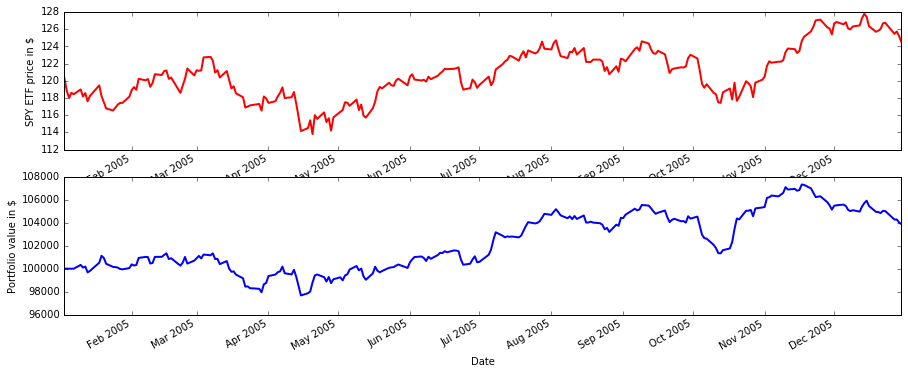

In [20]:
start_test = datetime.datetime(2005,1,1)
end_period = datetime.datetime(2005,12,31)

# Obtain the bars for SPY ETF which tracks the S&P500 index    
bars = DataReader("SPY", "yahoo", start_test, end_period)

# Create the S&P500 forecasting strategy
snpf = SNPForecastingStrategy("^GSPC", bars)
signals = snpf.generate_signals()

# Create the portfolio based on the forecaster
portfolio = MarketIntradayPortfolio("SPY", bars, signals,              
                                    initial_capital=100000.0)
returns = portfolio.backtest_portfolio()

# Plot results
fig = plt.figure()
fig.patch.set_facecolor('white')

# Plot the price of the SPY ETF
ax1 = fig.add_subplot(211,  ylabel='SPY ETF price in $')
bars['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the equity curve
ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
returns['total'].plot(ax=ax2, lw=2.)

plt.show()